In [70]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory  # pip install tf-nightly
from tensorflow.keras.callbacks import ModelCheckpoint

In [71]:
tf.debugging.set_log_device_placement(False)  # don't show device log
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [72]:
DATASET_DIR = "./augment_dataset/sdd"

TRAIN_DATASET_DIR = DATASET_DIR + '/train'

TEST_DATASET_DIR = DATASET_DIR + '/test'

IMG_SIZE = (32, 32)

BATCH_SIZE = 64

In [73]:
# build train dataset
train_ds = image_dataset_from_directory(directory=TRAIN_DATASET_DIR,
                                        labels='inferred',
                                        label_mode='categorical',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

#build test dataset
test_ds = image_dataset_from_directory(directory=TEST_DATASET_DIR,
                                       labels='inferred',
                                       label_mode='categorical',
                                       shuffle=False,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

Found 32458 files belonging to 120 classes.
Found 8222 files belonging to 120 classes.


In [74]:
# show dataset info
print("\ntraing dataset size:", len(train_ds))
print("test dataset size:", len(test_ds))
print("\nclass names:\n", train_ds.class_names)


traing dataset size: 254
test dataset size: 65

class names:
 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfol

train_imgs.shape:  (128, 32, 32, 3)
train_labels.shape:  (128, 120)
['n02098105-soft-coated_wheaten_terrier', 'n02095889-Sealyham_terrier', 'n02086240-Shih-Tzu', 'n02111889-Samoyed', 'n02097130-giant_schnauzer', 'n02112018-Pomeranian', 'n02098286-West_Highland_white_terrier', 'n02107574-Greater_Swiss_Mountain_dog', 'n02092002-Scottish_deerhound', 'n02091244-Ibizan_hound', 'n02106662-German_shepherd', 'n02112706-Brabancon_griffon', 'n02098105-soft-coated_wheaten_terrier', 'n02116738-African_hunting_dog', 'n02097658-silky_terrier', 'n02097658-silky_terrier', 'n02107683-Bernese_mountain_dog', 'n02105056-groenendael', 'n02098413-Lhasa', 'n02098286-West_Highland_white_terrier', 'n02116738-African_hunting_dog', 'n02113624-toy_poodle', 'n02086646-Blenheim_spaniel', 'n02113624-toy_poodle', 'n02087046-toy_terrier', 'n02094258-Norwich_terrier', 'n02094114-Norfolk_terrier', 'n02095570-Lakeland_terrier', 'n02085936-Maltese_dog', 'n02085936-Maltese_dog', 'n02109961-Eskimo_dog', 'n02113712-miniature

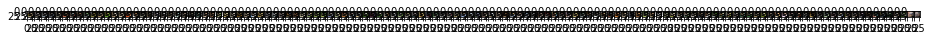

In [75]:
# show train batch
train_imgs, train_labels = next(iter(train_ds))

print("train_imgs.shape: ", train_imgs.shape)
print("train_labels.shape: ", train_labels.shape)

plt.figure(num=BATCH_SIZE, figsize=(16, 16))
for i, img in enumerate(train_imgs):
    plt.subplot(1, BATCH_SIZE, i + 1)
    plt.imshow(tf.make_ndarray(tf.make_tensor_proto(img)).astype('uint8'))

labels = [
    train_ds.class_names[np.where(label == 1)[0][0]] for label in train_labels
]
print(labels)

In [76]:
class BasicBlock(Model):
    def __init__(self, filters, kernel_size, padding='valid'):
        super(BasicBlock, self).__init__(name='')

        flt1, flt2 = filters

        self.conv1 = Conv2D(
            flt1,
            1,
            padding=padding,
            kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.dwcovn1 = SeparableConv2D(flt2, kernel_size, padding='same')

        self.conv2 = Conv2D(
            flt1,
            1,
            padding=padding,
            kernel_regularizer=tf.keras.regularizers.l2(l=0.003))

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

    def call(self, x):
        inp = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu6(x)
        #         print(x)

        x = self.dwcovn1(x)
        x = self.bn2(x)
        x = tf.nn.relu6(x)
        #         print(x)

        x = self.conv2(x)
        x = self.bn3(x)

        x += inp

        return x

In [77]:
img_shape = (64, 32, 32, 3)
blk = BasicBlock((3, 128), 3)
blk.build(img_shape)
print(blk.summary())

Model: "basic_block_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           multiple                  12        
_________________________________________________________________
separable_conv2d_18 (Separab multiple                  539       
_________________________________________________________________
conv2d_43 (Conv2D)           multiple                  387       
_________________________________________________________________
batch_normalization_66 (Batc multiple                  12        
_________________________________________________________________
batch_normalization_67 (Batc multiple                  512       
_________________________________________________________________
batch_normalization_68 (Batc multiple                  12        
Total params: 1,474
Trainable params: 1,206
Non-trainable params: 268
________________________________________________

In [78]:
class BokuNet(Model):
    def __init__(self):
        super(BokuNet, self).__init__(name='BokuNet')
        self.conv1 = Conv2D(32, 3, strides=2)
        self.block1 = BasicBlock((32, 64), 3)
        self.block2 = BasicBlock((32, 64), 3)
        
        self.avg_pool = AveragePooling2D()

        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(256, activation='relu')
        self.out_fc = Dense(120, activation='softmax')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        
#         self.drop1 = Dropout(0.5)
        
    def call(self, x):
        x = x / 255  # normalization

        y = self.conv1(x)
        y = tf.nn.relu(y)
        y = self.bn1(y)

        y = self.block1(y)
        y = tf.nn.relu(y)
        y = self.bn2(y)
        
        y = self.block2(y)
        y = tf.nn.relu(y)
        
        y = self.avg_pool(y)

        y = self.flatten(y)
        y = self.fc2(y)
        y = self.fc1(y)
        
#         y = self.drop1(y)

        y = self.out_fc(y)

        return y

In [79]:
model = BokuNet()
imgs, labels = next(iter(train_ds))
model.build(imgs.shape)
print(model.summary())

Model: "BokuNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           multiple                  896       
_________________________________________________________________
basic_block_19 (BasicBlock)  multiple                  6048      
_________________________________________________________________
basic_block_20 (BasicBlock)  multiple                  6048      
_________________________________________________________________
average_pooling2d_6 (Average multiple                  0         
_________________________________________________________________
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_18 (Dense)             multiple                  131584    
_________________________________________________________________
dense_19 (Dense)             multiple                  4016

In [80]:
EPOCHS = 10

checkpoint_path = "checkpoint/cp.ckpt"

if os.path.isfile(checkpoint_path):
    model.load_weights(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(train_ds),
                    validation_data=test_ds,
                    validation_steps=len(test_ds),
                    epochs=EPOCHS,
                    callbacks=[cp_callback])

Epoch 1/10
254/254 [==============================] - ETA: 0s - loss: 4.7511 - accuracy: 0.0417
Epoch 00001: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 94s 370ms/step - loss: 4.7511 - accuracy: 0.0417 - val_loss: 4.9837 - val_accuracy: 0.0146
Epoch 2/10
254/254 [==============================] - ETA: 0s - loss: 4.1901 - accuracy: 0.0881
Epoch 00002: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 96s 377ms/step - loss: 4.1901 - accuracy: 0.0881 - val_loss: 4.5823 - val_accuracy: 0.0482
Epoch 3/10
254/254 [==============================] - ETA: 0s - loss: 3.8652 - accuracy: 0.1277
Epoch 00003: saving model to checkpoint\cp.ckpt
254/254 [==============================] - 94s 371ms/step - loss: 3.8652 - accuracy: 0.1277 - val_loss: 4.1404 - val_accuracy: 0.0947
Epoch 4/10
254/254 [==============================] - ETA: 0s - loss: 3.5883 - accuracy: 0.1690
Epoch 00004: saving model to checkpoint\cp.ckpt
254/254 [=============

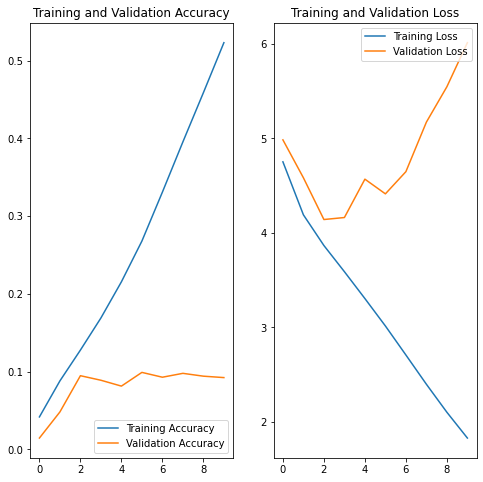

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()